### Using COLMAP Structure From Motion (SFM) Package

see <https://github.com/Fyusion/LLFF/tree/master> for more documentation

In [1]:
# import os
# import sys
# current = os.getcwd()
# sys.path.append(current+"/LLFF")

# from LLFF.llff.poses.pose_utils import gen_poses
# import sys

#<imgs2poses.py>:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--match_type', type=str, 
#                     default='exhaustive_matcher', help='type of matcher used.  Valid options: \
#                     exhaustive_matcher sequential_matcher.  Other matchers not supported at this time')
# parser.add_argument('scenedir', type=str,
#                     help='input scene directory')
# args = parser.parse_args()

# if args.match_type != 'exhaustive_matcher' and args.match_type != 'sequential_matcher':
#     print('ERROR: matcher type ' + args.match_type + ' is not valid.  Aborting')
#     sys.exit()

# if __name__=='__main__':
#     gen_poses(args.scenedir, args.match_type)

In [2]:
!ls

desk_demo.ipynb  HEIC2PNG.py	__init__.py  tiny_nerf
desk_images	 imgs2poses.py	LLFF


In [3]:
!python imgs2poses.py --match_type 'exhaustive_matcher' desk_images

Need to run COLMAP
[option_manager.cc:759] Check failed: ExistsDir(*image_path)
ERROR: Invalid options provided.
Traceback (most recent call last):
  File "/home/derm/ASAR/v3/nerf/imgs2poses.py", line 18, in <module>
    gen_poses(args.scenedir, args.match_type)
  File "/home/derm/ASAR/v3/nerf/LLFF/llff/poses/pose_utils.py", line 271, in gen_poses
    run_colmap(basedir, match_type)
  File "/home/derm/ASAR/v3/nerf/LLFF/llff/poses/colmap_wrapper.py", line 35, in run_colmap
    feat_output = ( subprocess.check_output(feature_extractor_args, universal_newlines=True) )
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/subprocess.py", line 424, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/home/derm/anaconda3/envs/py39/lib/python3.9/subprocess.py", line 528, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['colmap', 'feature_extractor', '--database_path', 'desk_images/database.db', '--image

(1000, 1000, 3)


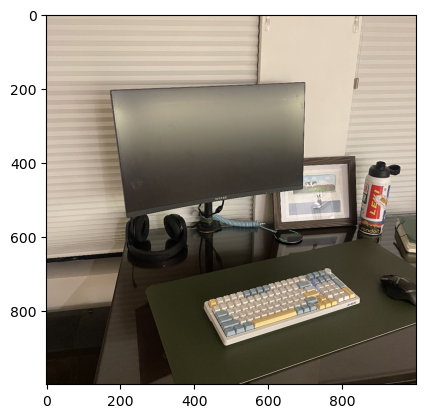

In [57]:
#convert HEIC images to PNG
from PIL import Image
from pillow_heif import register_heif_opener
from matplotlib import pyplot as plt
import numpy as np

register_heif_opener()

image_i = Image.open('desk_images/IMG_2072.HEIC')
i = np.asarray(image_i)
i = i[516:-516,12:-12,:] #crop square
i = i[::3,::3,:]
print(np.shape(i))
plt.imshow(i)


In [50]:
mega_image_array = np.append(mega_image_array, i[None,:,:,:], axis = 0)
print(np.shape(mega_image_array))

(10, 1000, 1000, 3)


In [68]:
#loop through subdirectory
import os
rootdir = 'desk_images'

# mega_image_array = np.zeros([0,1000,1000,3])

for subdir, dirs, files in os.walk(rootdir):
     for file in files:
        if file.endswith(("HEIC")):
            print(file)
            image_i = Image.open('desk_images/'+file)
            i = np.asarray(image_i)
            i = i[516:-516,12:-12,:] #crop square
            i = i[::3,::3,:]
#             mega_image_array = np.append(mega_image_array, i[None,:,:,:], axis = 0)
            im = Image.fromarray(i)
            im.save("desk_images/"+file[:-5]+'.PNG')


IMG_2116.HEIC
IMG_2087.HEIC
IMG_2081.HEIC
IMG_2126.HEIC
IMG_2158.HEIC
IMG_2082.HEIC
IMG_2151.HEIC
IMG_2140.HEIC
IMG_2156.HEIC
IMG_2145.HEIC
IMG_2157.HEIC
IMG_2141.HEIC
IMG_2124.HEIC
IMG_2100.HEIC
IMG_2073.HEIC
IMG_2089.HEIC
IMG_2088.HEIC
IMG_2149.HEIC
IMG_2104.HEIC
IMG_2139.HEIC
IMG_2160.HEIC
IMG_2142.HEIC
IMG_2134.HEIC
IMG_2072.HEIC
IMG_2125.HEIC
IMG_2095.HEIC
IMG_2119.HEIC
IMG_2144.HEIC
IMG_2138.HEIC
IMG_2108.HEIC
IMG_2079.HEIC
IMG_2090.HEIC
IMG_2136.HEIC
IMG_2075.HEIC
IMG_2109.HEIC
IMG_2128.HEIC
IMG_2076.HEIC
IMG_2074.HEIC
IMG_2147.HEIC
IMG_2103.HEIC
IMG_2122.HEIC
IMG_2085.HEIC
IMG_2106.HEIC
IMG_2159.HEIC
IMG_2094.HEIC
IMG_2133.HEIC
IMG_2098.HEIC
IMG_2080.HEIC
IMG_2118.HEIC
IMG_2077.HEIC
IMG_2093.HEIC
IMG_2155.HEIC
IMG_2123.HEIC
IMG_2148.HEIC
IMG_2096.HEIC
IMG_2114.HEIC
IMG_2137.HEIC
IMG_2083.HEIC
IMG_2117.HEIC
IMG_2110.HEIC
IMG_2135.HEIC
IMG_2107.HEIC
IMG_2112.HEIC
IMG_2154.HEIC
IMG_2129.HEIC
IMG_2143.HEIC
IMG_2120.HEIC
IMG_2099.HEIC
IMG_2121.HEIC
IMG_2078.HEIC
IMG_2101.HEIC
IMG_21

(1000, 1000, 3)


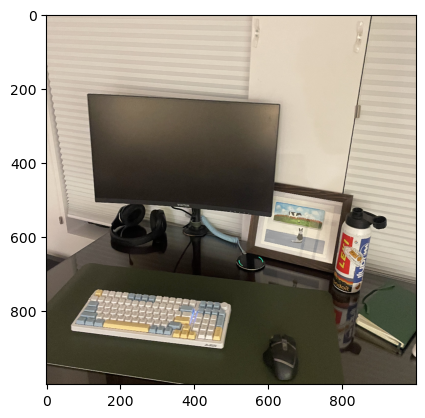

In [62]:
print(np.shape(mega_image_array[0]))
    
for n in range(10):
    plt.imshow(mega_image_array[n]/255)

In [69]:
# np.savez_compressed("desk_images", mega_image_array)

In [76]:
#load poses estimated by COLMAP
poses = np.fromfile("sparse/0/cameras.bin")
print(len(poses)//89)
pts3D = np.fromfile("sparse/0/points3D.bin")
print(len(pts3D))

7
269533


7
